# Species richness estimation

In [1]:
setwd("..")

## Installation

This notebook explores species richness estimation with `breakaway`, but I installed two packages from the StatDivLab in this environment, `breakaway` and `DivNet`.

Installing `Breakaway` and `DivNet` was a nightmare. I repeatedly tried installing them, and each time the installation exited with an error I installed the faulty packages with conda in the same env this notebook environment.

The first issue came from phyloseq, which both packages require. I installed phyloseq from bioconda, but even though conda installed the dependency `bioconductor-genomeinfodbdata`, it wasn't recognized by `library(phyloseq)`, so I installed it via bioconductor. After solving this issue, `Breakaway` installed from CRAN.

The next issue came with `DivNet`. `DivNet` requires `speedyseq`, which provides synonymous functions as found in phyloseq, but that are much faster. The package is only installable from it's github repo. I had to install `nloptr`, `mvnfast`, `castor` from conda, and then the package was able to install from github. Successful installation of `speedyseq` allowed `DivNet` to successfully install from github as well.

In [12]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("GenomeInfoDbData")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.2 (2021-11-01)

Installing package(s) 'GenomeInfoDbData'

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'GenomeInfoDb', 'mgcv', 'nloptr', 'rhdf5'



In [13]:
library(phyloseq)

In [14]:
install.packages("breakaway")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [21]:
library(nloptr)
library(mvnfast)
library(castor)

Loading required package: Rcpp


Attaching package: ‘castor’


The following object is masked from ‘package:phyloseq’:

    read_tree




In [22]:
remotes::install_github("mikemc/speedyseq")

Skipping 2 packages not available: Biostrings, phyloseq

Running `R CMD build`...



* checking for file ‘/private/var/folders/52/_yjsxstx0gl6n3bc1xfrfczr0000gn/T/RtmpUIk7Be/remotes1074d276bbf7b/mikemc-speedyseq-ceb941f/DESCRIPTION’ ... OK
* preparing ‘speedyseq’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘speedyseq_0.5.3.9018.tar.gz’


In [23]:
library(speedyseq)


Attaching package: ‘speedyseq’


The following objects are masked from ‘package:phyloseq’:

    filter_taxa, plot_bar, plot_heatmap, plot_tree, psmelt, tax_glom,
    tip_glom, transform_sample_counts




In [24]:
remotes::install_github("adw96/DivNet")

nloptr (1.2.2.3 -> 2.0.0) [CRAN]


Skipping 1 packages not available: phyloseq

Installing 1 packages: nloptr

Warning message:
“unable to access index for repository https://github.com/mikemc/speedyseq/src/contrib:
  cannot open URL 'https://github.com/mikemc/speedyseq/src/contrib/PACKAGES'”
Warning message in i.p(...):
“installation of package ‘nloptr’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Running `R CMD build`...



* checking for file ‘/private/var/folders/52/_yjsxstx0gl6n3bc1xfrfczr0000gn/T/RtmpUIk7Be/remotes1074d28618cf5/adw96-DivNet-0a17eb6/DESCRIPTION’ ... OK
* preparing ‘DivNet’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘DivNet_0.4.0.tar.gz’


In [40]:
library(readr)
library(dplyr)
library(purrr)
library(tidyr)
library(tibble)
library(ggplot2)
library(phyloseq)
library(breakaway)
library(DivNet)
source("scripts/utils.R")

In [26]:
# change default figure size
options(repr.plot.width=15, repr.plot.height=7)
# disable scientific notation (for plot axes)
options(scipen = 999)

## Read in gather results and sample metadata

In [27]:
# separate empty files from populated files
files <- Sys.glob("results/*gather.csv")
empty_files <- character()
populated_files <- character()
for(i in 1:length(files)){
    # check and see if the file is empty, e.g. has not gather matches
    file_size <- file.size(files[i])
    if(file_size == 0){
        empty_files = c(empty_files, files[i])
    } else {
        populated_files = c(populated_files, files[i])
    }
}

In [30]:
# read in populated files
gather_results <- populated_files %>%
  map_dfr(read_gather)

In [31]:
# join gather results with metadata
runinfo <- read_csv("all.runinfo.csv", show_col_types = F)
gather_results <- left_join(gather_results, runinfo, by = c("query_name" = "Run"))

Warning message:
“One or more parsing issues, see `problems()` for details”


# Breakaway: estimate per-sample diversity with standard errors and confidence intervals

limit to a single biome to begin with, something on the smaller side -- human skin metagenome

by default, breakaway assumes that genomes/species/etc. are rows and samples are columns.

## Trial with human skin metagenome

### Try using genomes first

In [32]:
gather_subset <- gather_results %>%
  filter(ScientificName == "human skin metagenome")

length(unique(gather_subset$query_name))

[1] 220

In [33]:
head(gather_subset)

intersect_bp,f_orig_query,f_match,f_unique_to_query,f_unique_weighted,average_abund,median_abund,std_abund,name,filename,⋯,Affection_Status,Analyte_Type,Histological_Type,Body_Site,CenterName,Submission,dbgap_study_accession,Consent,RunHash,ReadHash
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<lgl>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
100000,0.5000000,0.05882353,0.5000000,0.50000000,1,1,0,"GCA_902787875.1 uncultured Clostridiales bacterium, Rumen uncultured genome RUG13316",/home/ctbrown/scratch/cover/gtdb-rs202.genomic.k31.cover.zip,⋯,NA,NA,NA,UBERON:skinofhead,UNIVERSITY OF CALIFORNIA SAN DIEGO MICROBIOME INIT,ERA486171,NA,public,B7A29981DE923CA4571F73964E2E56C8,ABB5126CC3F5A6C5069879198DC8C96C
100000,0.1428571,0.01851852,0.1428571,0.50000000,11,11,0,"GCA_900471415.1 Rhizobiales bacterium, AFS072142",/home/ctbrown/scratch/cover/gtdb-rs202.genomic.k31.cover.zip,⋯,NA,NA,NA,UBERON:skin of hand,UNIVERSITY OF CALIFORNIA SAN DIEGO MICROBIOME INIT,ERA524637,NA,public,0FFFE546D3C46C9CDFD3C3E221CC0AA0,BE6353A33CC3BB32001005291BD2E5F1
100000,0.1428571,0.05882353,0.1428571,0.18181818,4,4,0,"GCA_902787875.1 uncultured Clostridiales bacterium, Rumen uncultured genome RUG13316",/home/ctbrown/scratch/cover/gtdb-rs202.genomic.k31.cover.zip,⋯,NA,NA,NA,UBERON:skin of hand,UNIVERSITY OF CALIFORNIA SAN DIEGO MICROBIOME INIT,ERA524637,NA,public,0FFFE546D3C46C9CDFD3C3E221CC0AA0,BE6353A33CC3BB32001005291BD2E5F1
100000,0.1428571,0.01694915,0.1428571,0.04545455,1,1,0,"GCF_000751295.2 bacterium YEK0313, ASM75129v2",/home/ctbrown/scratch/cover/gtdb-rs202.genomic.k31.cover.zip,⋯,NA,NA,NA,UBERON:skin of hand,UNIVERSITY OF CALIFORNIA SAN DIEGO MICROBIOME INIT,ERA524637,NA,public,0FFFE546D3C46C9CDFD3C3E221CC0AA0,BE6353A33CC3BB32001005291BD2E5F1
100000,0.1000000,0.05882353,0.1000000,0.05000000,1,1,0,"GCA_902787875.1 uncultured Clostridiales bacterium, Rumen uncultured genome RUG13316",/home/ctbrown/scratch/cover/gtdb-rs202.genomic.k31.cover.zip,⋯,NA,NA,NA,UBERON:skin,UNIVERSITY OF CALIFORNIA SAN DIEGO MICROBIOME INIT,ERA525236,NA,public,B5EF1677206853588C8A68FF25423F9C,9DA321B8837FFACD5E690541A08B8637
100000,0.1000000,0.02941176,0.1000000,0.30000000,6,6,0,"GCF_003043945.1 Prevotella sp. oral taxon 376 strain=F0043, ASM304394v1",/home/ctbrown/scratch/cover/gtdb-rs202.genomic.k31.cover.zip,⋯,NA,NA,NA,UBERON:skin,UNIVERSITY OF CALIFORNIA SAN DIEGO MICROBIOME INIT,ERA525236,NA,public,B5EF1677206853588C8A68FF25423F9C,9DA321B8837FFACD5E690541A08B8637


In [66]:
gather_subset_formatted <- gather_subset %>%
  mutate(accession = gsub(" .*", "", name)) %>% # make genome names more friendly
  mutate(n_kmers = (average_abund * unique_intersect_bp)/ 10000) %>%
  select(query_name, accession, n_kmers) %>%
  distinct() %>% # somehow duplicates snuck in?
  pivot_wider(id_cols = c("accession"), names_from = query_name, values_from = n_kmers) %>%
  column_to_rownames("accession") %>%
  replace(is.na(.), 0) %>%
  mutate(across(where(is.numeric), as.integer)) %>%
  replace(is.na(.), 0)

head(gather_subset_formatted)

,ERR1021380,ERR1073633,ERR1076102,ERR1076495,ERR1076743,ERR1076839,ERR1086173,ERR1086546,ERR1086620,ERR1086829,⋯,SRR7992548,SRR7992646,SRR7992806,SRR9965426,SRR9965434,SRR9965653,SRR9965770,SRR9965894,SRR9965907,SRR9965965
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
GCA_902787875.1,10,40,10,0,10,30,2110,0,0,0,⋯,10,0,20,0,0,0,0,0,0,0
GCA_900471415.1,0,110,0,0,0,0,490,0,1130,0,⋯,0,0,0,0,0,0,0,0,0,0
GCF_000751295.2,0,10,0,0,0,0,0,0,0,0,⋯,0,0,50,0,0,0,0,0,0,0
GCF_003043945.1,0,0,60,40,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
GCA_014062385.1,0,0,0,0,0,0,0,10,0,0,⋯,0,0,0,0,0,0,0,0,0,0
GCF_009743685.1,0,0,0,0,0,0,0,0,0,10,⋯,0,0,0,280,160,90,200,120,80,10


In [74]:
max(gather_subset_formatted)

[1] 976380

In [77]:
try_breakaway <- gather_subset_formatted %>%
  breakaway()

Warning message in breakaway.data.frame(.):
“Assuming taxa are rows”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Cut-off was too low: no data available for estimation”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Cut-off was too low: no data available for estimation”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Cut-off was too low: no data available for estimation”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Cut-off was too low: no data available for estimation”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Cut-off was too low: no data available for estimation”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Cut-off was too low: no data available for estimation”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Cut-off was too low: no data available for estimation”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Cut-off was too low: no data avail

Warning message:
“Removed 16 rows containing missing values (geom_segment).”


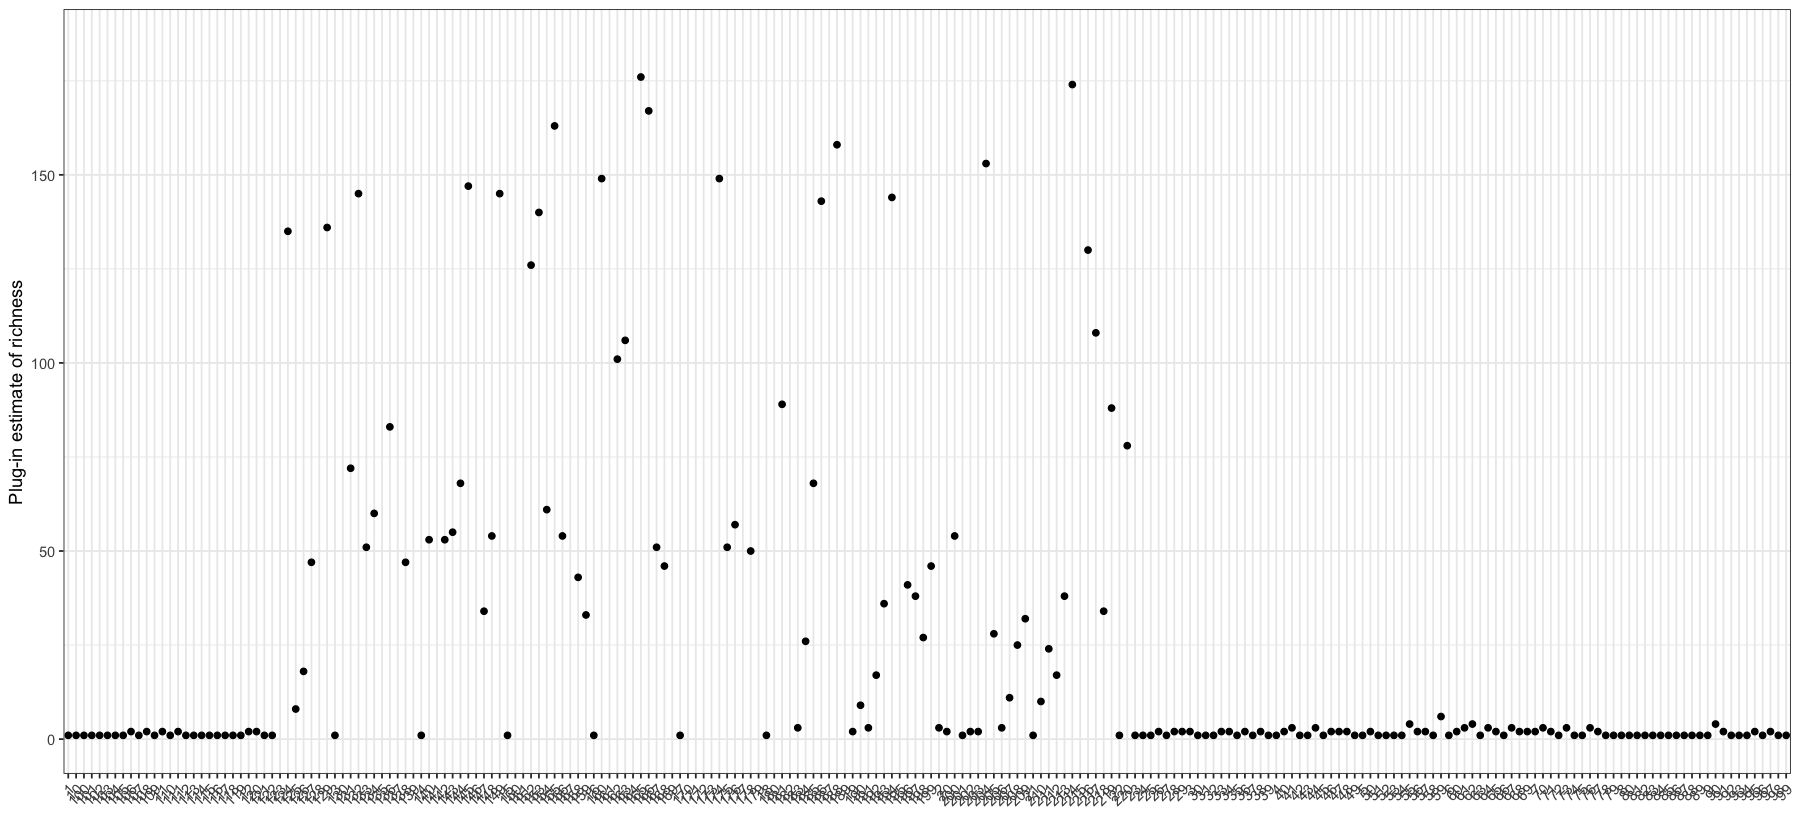

In [87]:
plot(try_breakaway)

There's no confidence interval with the associated results; that might be related to this issue: https://github.com/adw96/breakaway/issues/106#issuecomment-799741111

It wouldn't be terribly out the realm of possibility for `breakaway()` to just be returning the number of observed species -- skin isn't a super complex microbiome, so it might make sense?

With regards to 
```
Warning message in poisson_model(input_data, cutoff = cutoff):
“Cut-off was too low: no data available for estimation”
```
I originally used `intersect_bp_weighted = (average_abund * unique_intersect_bp)` as the estimate to use for richness calculation. It took a really long time to run, and produced many more of the `cut-off` error, but produced the same plot as seen above except with 144 missing samples...so I switched to `num_kmers`.


In [ ]:
colSums(gather_subset_formatted)

In [58]:
table(rowSums(gather_subset_formatted) > 0)


TRUE 
6014 

In [57]:
dim(gather_subset_formatted)

[1] 6014  220

### Try summarizing to speices

In [59]:
gtdb_lineages <- read_csv("https://osf.io/p6z3w/download")

Rows: 258406 Columns: 8
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (8): ident, superkingdom, phylum, class, order, family, genus, species

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [80]:
gather_subset_formatted_species <- gather_subset %>%
  mutate(accession = gsub(" .*", "", name)) %>% # make genome names more friendly
  mutate(n_kmers = (average_abund * unique_intersect_bp) / 100000) %>%
  left_join(gtdb_lineages, by = c("accession" = "ident")) %>%
  group_by(query_name, species) %>%
  summarize(sum_kmers = sum(n_kmers)) %>%
  distinct() %>% # somehow duplicates snuck in?
  pivot_wider(id_cols = c("species"), names_from = query_name, values_from = sum_kmers) %>%
  column_to_rownames("species") %>%
  replace(is.na(.), 0) %>%
  mutate(across(where(is.numeric), as.integer)) %>%
  replace(is.na(.), 0)

`summarise()` has grouped output by 'query_name'. You can override using the `.groups` argument.


In [81]:
head(gather_subset_formatted_species)

,ERR1021380,ERR1073633,ERR1076102,ERR1076495,ERR1076743,ERR1076839,ERR1086173,ERR1086546,ERR1086620,ERR1086829,⋯,SRR7992548,SRR7992646,SRR7992806,SRR9965426,SRR9965434,SRR9965653,SRR9965770,SRR9965894,SRR9965907,SRR9965965
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
s__RUG13615 sp902790905,1,4,1,0,1,3,211,0,0,0,⋯,1,0,2,0,0,0,0,0,0,0
s__Bosea sp900466745,0,11,0,0,0,0,49,0,113,0,⋯,0,0,0,0,0,0,0,0,0,0
s__Phreatobacter sp000751295,0,1,0,0,0,0,0,0,0,0,⋯,0,0,5,0,0,0,0,0,0,0
s__Prevotella sp003043945,0,0,6,4,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
s__Pseudomonas_E carnis,0,0,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,4
s__Escherichia flexneri,0,0,0,0,0,0,0,0,0,1,⋯,1797,3629,1570,761,402,231,405,188,410,389


In [82]:
dim(gather_subset_formatted_species)

[1] 3292  220

In [114]:
max(gather_subset_formatted_species)

[1] 99000

In [118]:
try_breakaway_species <- gather_subset_formatted_species %>%
  breakaway()

Warning message in breakaway.data.frame(.):
“Assuming taxa are rows”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Cut-off was too low: no data available for estimation”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency coun

Warning message:
“Removed 1 rows containing missing values (geom_segment).”


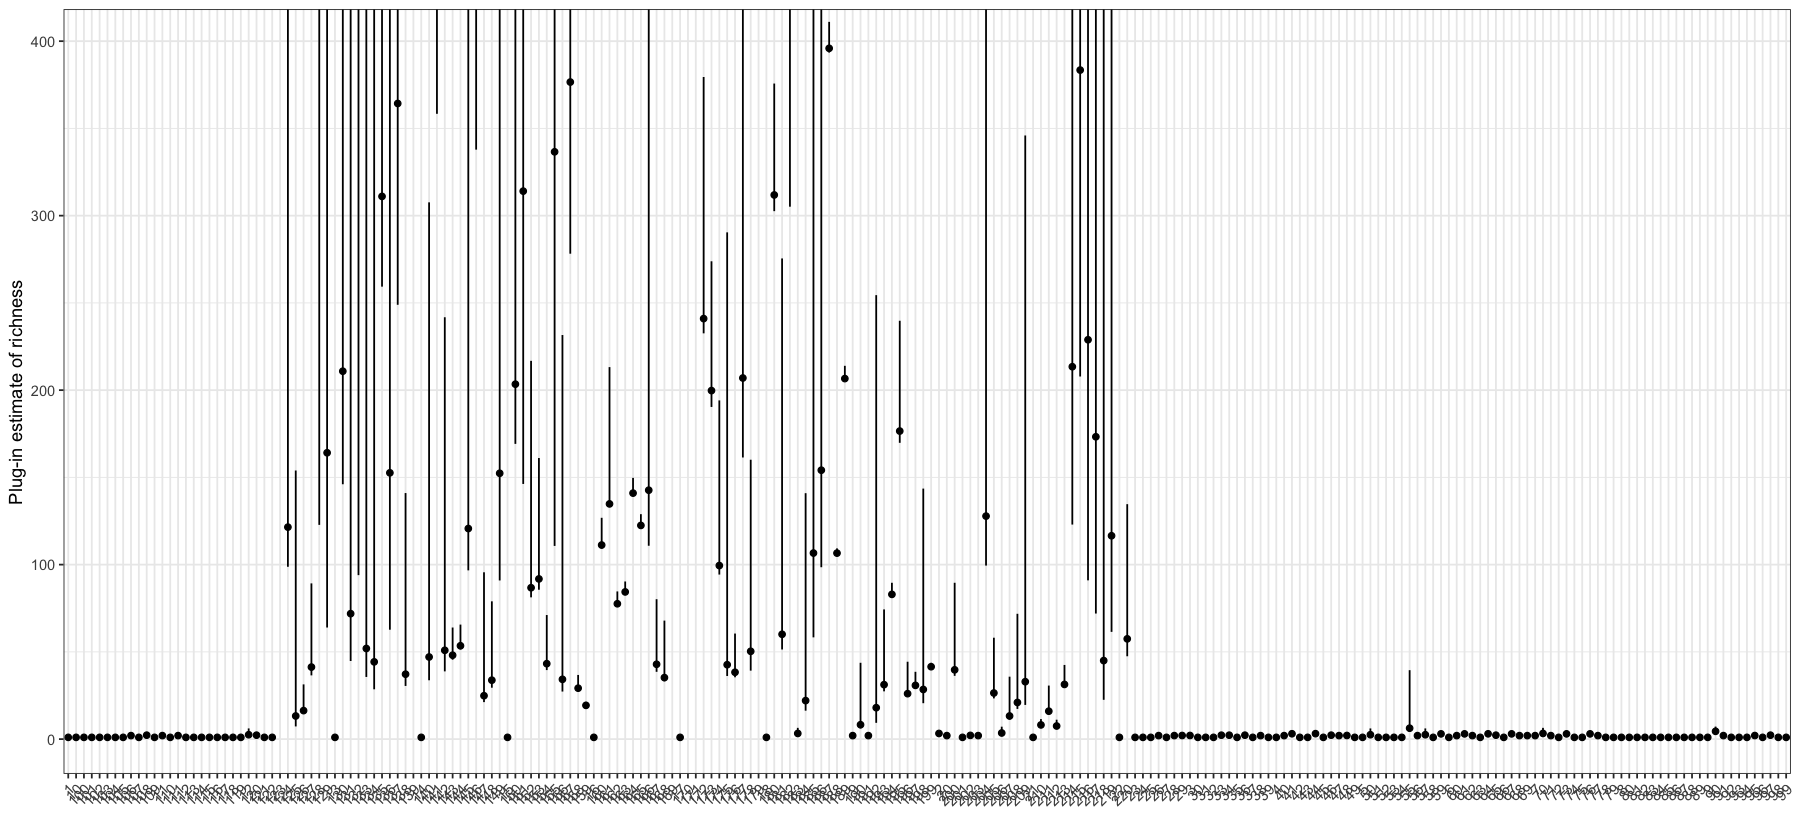

In [86]:
plot(try_breakaway_species)

## Trial with all samples that were annotated by MGnify (1293 samples)

In [93]:
ebi <- read_csv("ebi_mgnify_samples.csv", show_col_types = F)

In [98]:
gather_ebi <- left_join(gather_results, ebi, by = c("Sample" = "accession"))

In [104]:
gather_ebi <- gather_ebi %>% 
  filter(!is.na(biome))

In [105]:
gather_ebi%>%
  select(query_name, biome) %>%
  distinct() %>% 
  group_by(biome) %>%
  tally() %>%
  arrange(desc(n)) %>%
  head()

length(unique(gather_results_ebi$query_name))

biome,n
<chr>,<int>
root:Host-associated:Human:Digestive system:Large intestine:Fecal,456
root:Mixed,109
root:Host-associated:Human,75
root:Environmental:Aquatic:Marine,69
root:Host-associated:Human:Digestive system,61
root:Host-associated:Mammals:Digestive system:Large intestine:Fecal,48


[1] 1293

In [106]:
gather_ebi_formatted_species <- gather_ebi %>%
  mutate(accession = gsub(" .*", "", name)) %>% # make genome names more friendly
  mutate(n_kmers = (average_abund * unique_intersect_bp) / 100000) %>%
  left_join(gtdb_lineages, by = c("accession" = "ident")) %>%
  group_by(query_name, species) %>%
  summarize(sum_kmers = sum(n_kmers)) %>%
  distinct() %>% # somehow duplicates snuck in?
  pivot_wider(id_cols = c("species"), names_from = query_name, values_from = sum_kmers) %>%
  column_to_rownames("species") %>%
  replace(is.na(.), 0) %>%
  mutate(across(where(is.numeric), as.integer)) %>%
  replace(is.na(.), 0)

`summarise()` has grouped output by 'query_name'. You can override using the `.groups` argument.


In [107]:
try_breakaway__ebi_species <- gather_ebi_formatted_species %>%
  breakaway()

Warning message in breakaway.data.frame(.):
“Assuming taxa are rows”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff)

Warning message:
“Removed 1 rows containing missing values (geom_segment).”


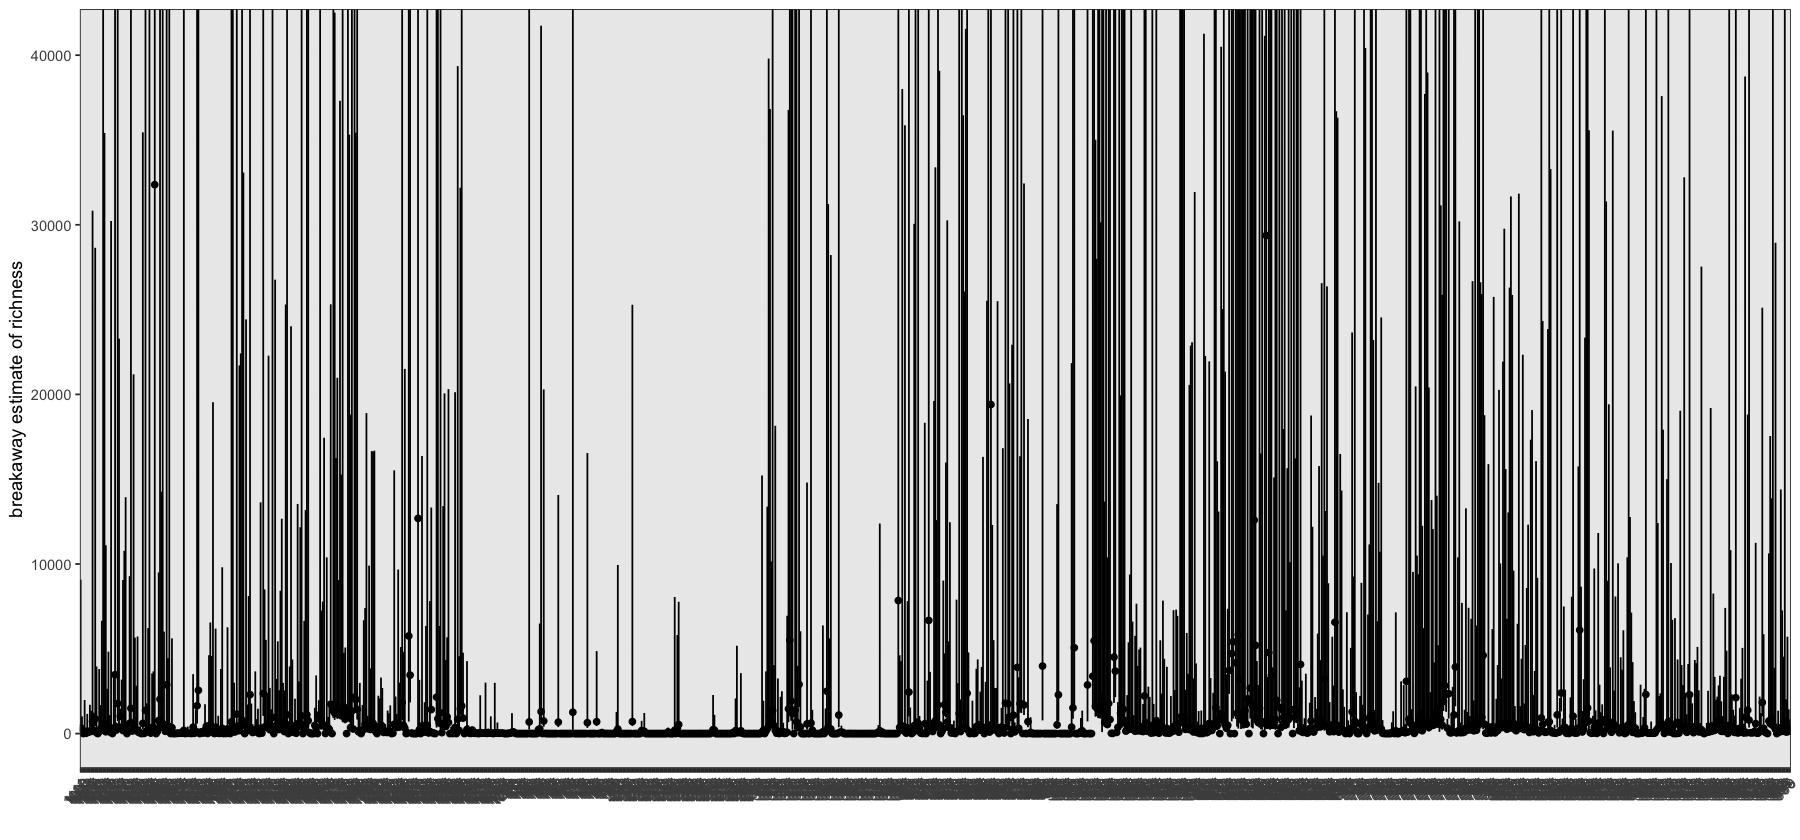

In [108]:
plot(try_breakaway__ebi_species)

## Run the whole 10k, because why not.

In [110]:
gather_formatted_species <- gather_results %>%
  mutate(accession = gsub(" .*", "", name)) %>% # make genome names more friendly
  mutate(n_kmers = (average_abund * unique_intersect_bp) / 100000) %>%
  left_join(gtdb_lineages, by = c("accession" = "ident")) %>%
  group_by(query_name, species) %>%
  summarize(sum_kmers = sum(n_kmers)) %>%
  distinct() %>% # somehow duplicates snuck in?
  pivot_wider(id_cols = c("species"), names_from = query_name, values_from = sum_kmers) %>%
  filter(!is.na(species)) %>%   # urm some of the species are NA? shouldn't happen, but just remove those rows
  column_to_rownames("species") %>%
  replace(is.na(.), 0) %>%
  mutate(across(where(is.numeric), as.integer)) %>%
  replace(is.na(.), 0)

`summarise()` has grouped output by 'query_name'. You can override using the `.groups` argument.


In [120]:
try_breakaway_species <- gather_formatted_species %>%
  breakaway()

Warning message in breakaway.data.frame(.):
“Assuming taxa are rows”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Cut-off was too low: no data available for estimation”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency coun

Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Cut-off was too low: no data available for estimation”
Warning mes

Warning message in summary.lm(lm2):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(lm2):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(lm2):
“essentially perfect fit: summary may be unreliable”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Cut-off was too low: no data available for estimation”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in summary.lm(lm2):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(lm2):
“essentially perfect fit: summary may be unreliable”
W

Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider incre

Warning message in poisson_model(input_data, cutoff = cutoff):
“Cut-off was too low: no data available for estimation”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Cut-off was too low: no data available for estimation”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Cut-off was too low: no data available for estimation”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Cut-off was too low: no data available for estimation”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Cut-off was too low: no d

Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Only one frequency count was observed below cutoff.
Consider increasing cutoff.”
Warning message in poisson_model(input_data, cutoff = cutoff):
“Cut-off was too low: no data available for estimation”
Warning mes

Warning message:
“Removed 45 rows containing missing values (geom_segment).”


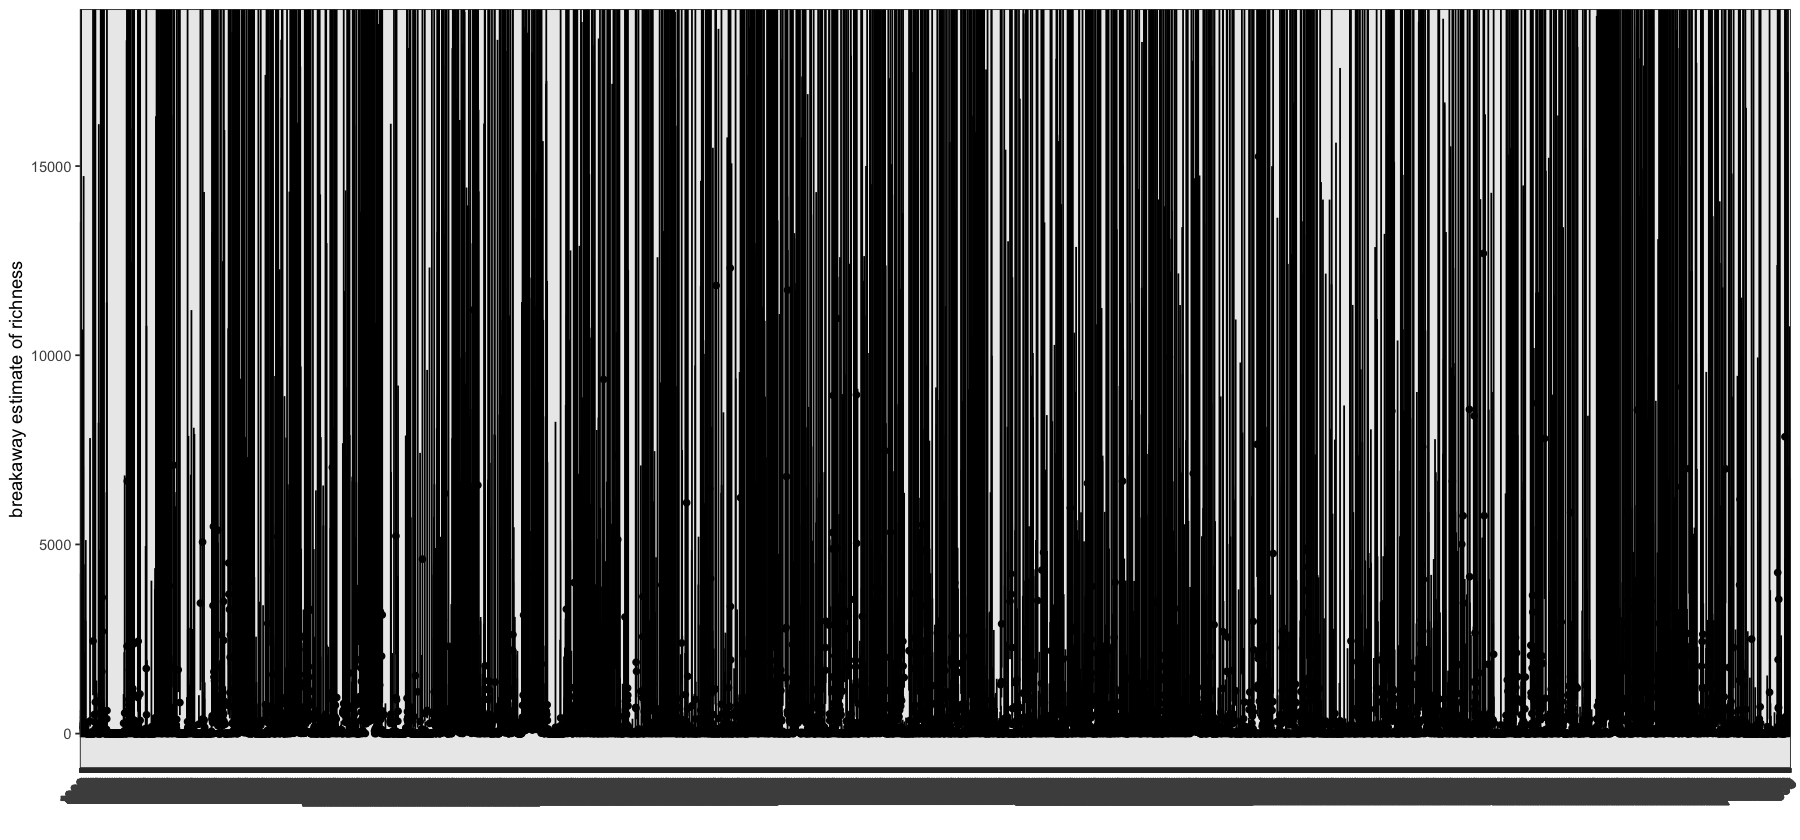

In [121]:
plot(try_breakaway_species)

Ok these plots are attrociously ugly, but the good news is that it wasn't a big deal to run this code once the packages were installed. I'm fairly hopeful that it will run relatively quickly on the full data set. Next steps are to look into using the `betta` function to test for differences in diversity between sets of metagenomes.

See this tutorial -- https://cran.r-project.org/web/packages/breakaway/vignettes/diversity-hypothesis-testing.html